In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, expon, gamma, lognorm, weibull_min


path = 'surgery_data.xlsx'
df = pd.read_excel(path)

df

,Surgery Type,Value (min)
0,Simple Surgery,19.88
1,Simple Surgery,16.33
2,Moderate Surgery,78.88
3,Moderate Surgery,60.03
4,Moderate Surgery,83.10
...,...,...
3995,Simple Surgery,26.10
3996,Simple Surgery,37.46
3997,Moderate Surgery,72.61
3998,Simple Surgery,24.62


In [2]:
# Rename columns because doos daram
df.columns = ['type', 'duration']

### First, check for null and invalid data.

In [3]:
surgery_types = df["type"].unique()
surgery_types

array(['Simple Surgery', 'Moderate Surgery', 'Complex Surgery'],
      dtype=object)

In [4]:
(df["duration"]< 0).sum()

np.int64(0)

In [5]:
(df["duration"].isna()).sum() , (df["duration"].isnull()).sum()

(np.int64(0), np.int64(0))

In [6]:
np.isfinite(df["duration"]).sum() , df.shape

(np.int64(4000), (4000, 2))

In [7]:
# Ensure the duration column contains valid numeric values
df["duration"] = pd.to_numeric(df["duration"], errors='coerce')

df["duration"].describe()

count    4000.000000
mean       60.756758
std        49.511212
min        14.410000
25%        30.190000
50%        44.290000
75%        75.942500
max       408.130000
Name: duration, dtype: float64

### Time to visualize the data to identify irregularities, if any exist.

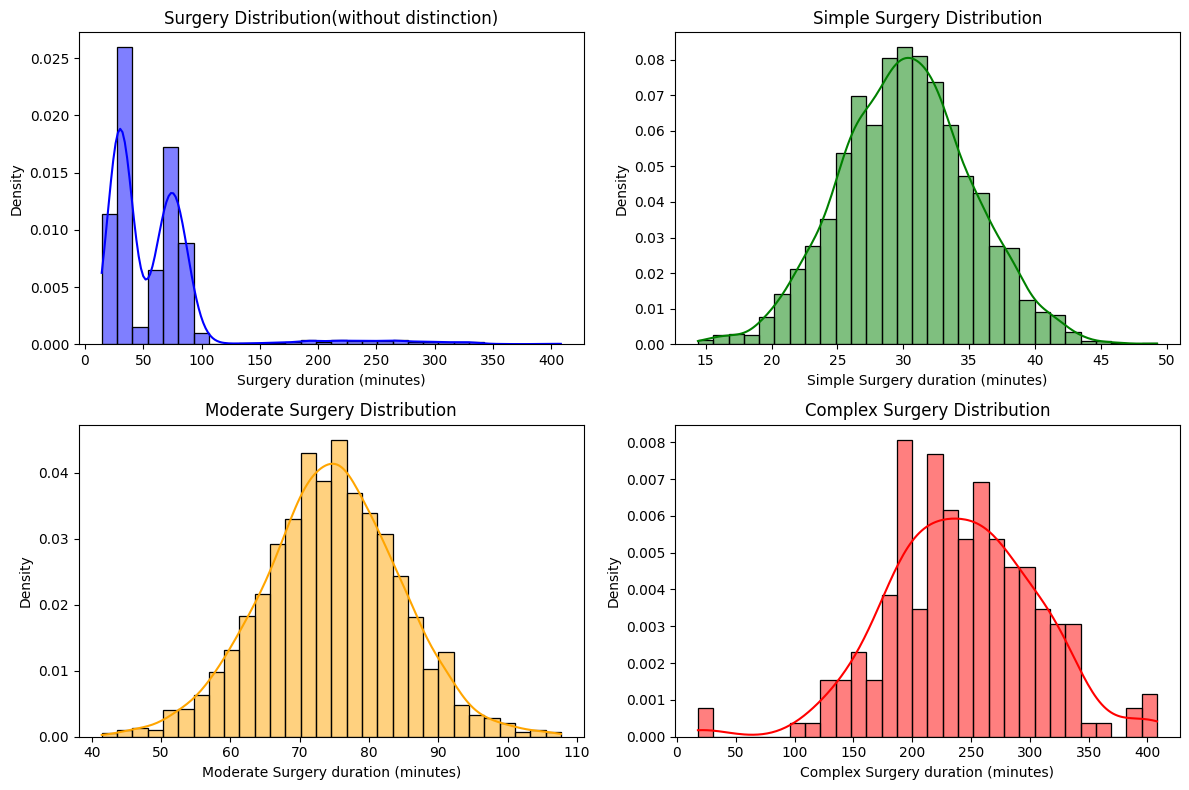

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 x 2 plots

# Plot 1: Surgery Distribution(without distinction)
sns.histplot(df["duration"], bins=30, kde=True, stat="density", color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Surgery Distribution(without distinction)')
axes[0, 0].set_xlabel('Surgery duration (minutes)')
axes[0, 0].set_ylabel('Density')

# Plot 2: Simple Surgery
sns.histplot(df.loc[df["type"] == "Simple Surgery"]["duration"], bins=30, kde=True, stat="density", color='green', ax=axes[0, 1])
axes[0, 1].set_title('Simple Surgery Distribution')
axes[0, 1].set_xlabel('Simple Surgery duration (minutes)')
axes[1, 0].set_ylabel('Density')

# Plot 3: Moderate Surgery
sns.histplot(df.loc[df["type"] == "Moderate Surgery"]["duration"], bins=30, kde=True, stat="density", color='orange', ax=axes[1, 0])
axes[1, 0].set_title('Moderate Surgery Distribution')
axes[1, 0].set_xlabel('Moderate Surgery duration (minutes)')
axes[1, 0].set_ylabel('Density')

# Plot 4: Complex Surgery
sns.histplot(df.loc[df["type"] == "Complex Surgery"]["duration"], bins=30, kde=True, stat="density", color='red', ax=axes[1, 1])
axes[1, 1].set_title('Complex Surgery Distribution')
axes[1, 1].set_xlabel('Complex Surgery duration (minutes)')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()

plt.show()



### * Distinctly, they are highly likely to follow a normal distribution.

## We need to validate this hypothesis by performing a "KS test" across various distributions.

In [9]:
class FittingDistributions:
    '''
    Fitting various distributions and testing them to
    find most-fitted one given a specific series of
    data

    '''
    
    def __init__(self,  _series_: pd.Series, descriptive_name: str) -> None:
        self._series_ = _series_
        self.descriptive_name = descriptive_name
        self.__best_fit_name__ = None
        self.__best_fit_params__ = None

        # Fitting normal, exponential, gamma, LogNormal, and Weibull distribution
        self.normal_params = self.__normal_fitting__()
        self.exponential_params = self.__exponential_fitting__()
        self.gamma_params = self.__gamma_fitting__()
        self.lognormal_params = self.__lognormal_fitting__()
        self.weibull_params = self.__weibull_fitting__()

        pass

    @property
    def best_fit_dist_name(self):
        return self.__best_fit_name__
    
    @property
    def best_fit_dist_params(self):
        return self.__best_fit_params__
    

    # Different distributions fitting
    def __normal_fitting__(self):
        return norm.fit(self._series_)

    def __exponential_fitting__(self):
        return expon.fit(self._series_)

    def __gamma_fitting__(self):
        return gamma.fit(self._series_)

    def __lognormal_fitting__(self):
        return lognorm.fit(self._series_)

    def __weibull_fitting__(self):
        return weibull_min.fit(self._series_)

    # Different ks tests
    @property
    def normal_ks_test(self):
        return stats.kstest(self._series_, 'norm', self.normal_params)

    @property
    def exponential_ks_test(self):
        return stats.kstest(self._series_, 'expon', self.exponential_params)

    @property
    def gamma_ks_test(self):
        return stats.kstest(self._series_, 'gamma', self.gamma_params)

    @property
    def lognormal_ks_test(self):
        return stats.kstest(self._series_, 'lognorm', self.lognormal_params)

    @property
    def weibull_ks_test(self):
        return stats.kstest(self._series_, 'weibull_min', self.weibull_params)


    def find_best_fitting(self):
        '''
        finding best fitting distribution via ks_test

        '''

        ks_tests = {"normal": self.normal_ks_test, "exponential": self.exponential_ks_test,
                    "gamma": self.gamma_ks_test, "lognormal": self.lognormal_ks_test,
                    "weibull": self.weibull_ks_test}
            
        print("***", self.descriptive_name.upper(), "***")

        best_ks_stat = None
        for dist, ks in ks_tests.items():
            print(f"{dist.upper()} KS Statistic: {ks}")

            # if best_ks_stat is None:
            #     best_ks_stat = ks
            #     continue
            
            if (best_ks_stat is None) or (ks < best_ks_stat):
                best_fit_params = getattr(self, dist + "_params")
                best_name = dist
                best_ks_stat = ks


        self.__best_fit_name__ = best_name
        self.__best_fit_params__ = best_fit_params

        print(20* "-" + ">")
        print(f"Best fitting distribution: {best_name} with params {best_fit_params}")
        print("###" + 20* "--" + "###")

    @staticmethod
    def generate_random_number(dist_name : str, size: int, params: tuple) -> np.array:
        match dist_name.lower():
            case "normal":
                random_durations = norm.rvs(*params, size=size)
            case "exponential":
                random_durations = expon.rvs(*params, size=size)
            case "gamma":
                random_durations = gamma.rvs(*params, size=size)
            case "lognormal":
                random_durations = lognorm.rvs(*params, size=size)
            case "weibull":
                random_durations = weibull_min.rvs(*params, size=size)
            case _:
                print(f"Unsupported distribution: {dist_name}")

        return random_durations

In [10]:
simple_surgery = FittingDistributions(df[df["type"] == "Simple Surgery"]["duration"]
, descriptive_name= "Simple Surgery" )
simple_surgery.find_best_fitting()

*** SIMPLE SURGERY ***
NORMAL KS Statistic: KstestResult(statistic=np.float64(0.011249898056094998), pvalue=np.float64(0.9594472125135786), statistic_location=np.float64(33.57), statistic_sign=np.int8(1))
EXPONENTIAL KS Statistic: KstestResult(statistic=np.float64(0.3553260949212742), pvalue=np.float64(1.91029707550061e-226), statistic_location=np.float64(24.31), statistic_sign=np.int8(-1))
GAMMA KS Statistic: KstestResult(statistic=np.float64(0.010302847856003994), pvalue=np.float64(0.9822993321413912), statistic_location=np.float64(33.57), statistic_sign=np.int8(1))
LOGNORMAL KS Statistic: KstestResult(statistic=np.float64(0.010296555833139709), pvalue=np.float64(0.982411074107183), statistic_location=np.float64(33.57), statistic_sign=np.int8(1))
WEIBULL KS Statistic: KstestResult(statistic=np.float64(0.021883613658149836), pvalue=np.float64(0.2893671745136027), statistic_location=np.float64(33.57), statistic_sign=np.int8(1))
-------------------->
Best fitting distribution: lognormal

In [11]:
moderate_surgery = FittingDistributions(df[df["type"] == "Moderate Surgery"]["duration"]
, descriptive_name= "Moderate Surgery" )
moderate_surgery.find_best_fitting()

*** MODERATE SURGERY ***
NORMAL KS Statistic: KstestResult(statistic=np.float64(0.015484272560528312), pvalue=np.float64(0.775067070792439), statistic_location=np.float64(69.37), statistic_sign=np.int8(-1))
EXPONENTIAL KS Statistic: KstestResult(statistic=np.float64(0.36088152772605075), pvalue=np.float64(1.8087893114906007e-210), statistic_location=np.float64(61.35), statistic_sign=np.int8(-1))
GAMMA KS Statistic: KstestResult(statistic=np.float64(0.016199890915928106), pvalue=np.float64(0.7258566169605918), statistic_location=np.float64(69.37), statistic_sign=np.int8(-1))
LOGNORMAL KS Statistic: KstestResult(statistic=np.float64(0.015489155766079898), pvalue=np.float64(0.7747390280322182), statistic_location=np.float64(69.37), statistic_sign=np.int8(-1))
WEIBULL KS Statistic: KstestResult(statistic=np.float64(0.023269037297363654), pvalue=np.float64(0.2796192456786234), statistic_location=np.float64(66.71), statistic_sign=np.int8(-1))
-------------------->
Best fitting distribution: 

In [12]:
complex_surgery = FittingDistributions(df[df["type"] == "Complex Surgery"]["duration"]
, descriptive_name= "Complex Surgery" )
complex_surgery.find_best_fitting()

*** COMPLEX SURGERY ***
NORMAL KS Statistic: KstestResult(statistic=np.float64(0.037211610272123025), pvalue=np.float64(0.934868974292601), statistic_location=np.float64(188.28), statistic_sign=np.int8(-1))
EXPONENTIAL KS Statistic: KstestResult(statistic=np.float64(0.39731528915993714), pvalue=np.float64(5.464782531606365e-29), statistic_location=np.float64(154.86), statistic_sign=np.int8(-1))
GAMMA KS Statistic: KstestResult(statistic=np.float64(0.04033268204402152), pvalue=np.float64(0.8876298288304696), statistic_location=np.float64(188.28), statistic_sign=np.int8(-1))
LOGNORMAL KS Statistic: KstestResult(statistic=np.float64(0.03721202261763454), pvalue=np.float64(0.9348636368682837), statistic_location=np.float64(188.28), statistic_sign=np.int8(-1))
WEIBULL KS Statistic: KstestResult(statistic=np.float64(0.0489593215025388), pvalue=np.float64(0.7049586612988556), statistic_location=np.float64(174.54), statistic_sign=np.int8(-1))
-------------------->
Best fitting distribution: no

## All we have done so far was in purpose of generating a surgery duration for a patient, given the type.



In [13]:
# generate_random_number functions
simple_generated_durations = simple_surgery.generate_random_number(simple_surgery.best_fit_dist_name, size= 1000, 
                                        params= simple_surgery.best_fit_dist_params)

moderate_generated_durations = moderate_surgery.generate_random_number(moderate_surgery.best_fit_dist_name, size= 1000, 
                                        params= moderate_surgery.best_fit_dist_params)

complex_generated_durations = complex_surgery.generate_random_number(complex_surgery.best_fit_dist_name, size= 1000, 
                                        params= complex_surgery.best_fit_dist_params)


In [14]:
# Union of all surgeries generated data
all_generated_durations = np.concatenate((complex_generated_durations, simple_generated_durations, moderate_generated_durations))
all_generated_durations.shape

(3000,)

## Now, it's time to visualize the generated random variables.
### Note that the original data and generated data are illustrated in blue and orange, respectively.

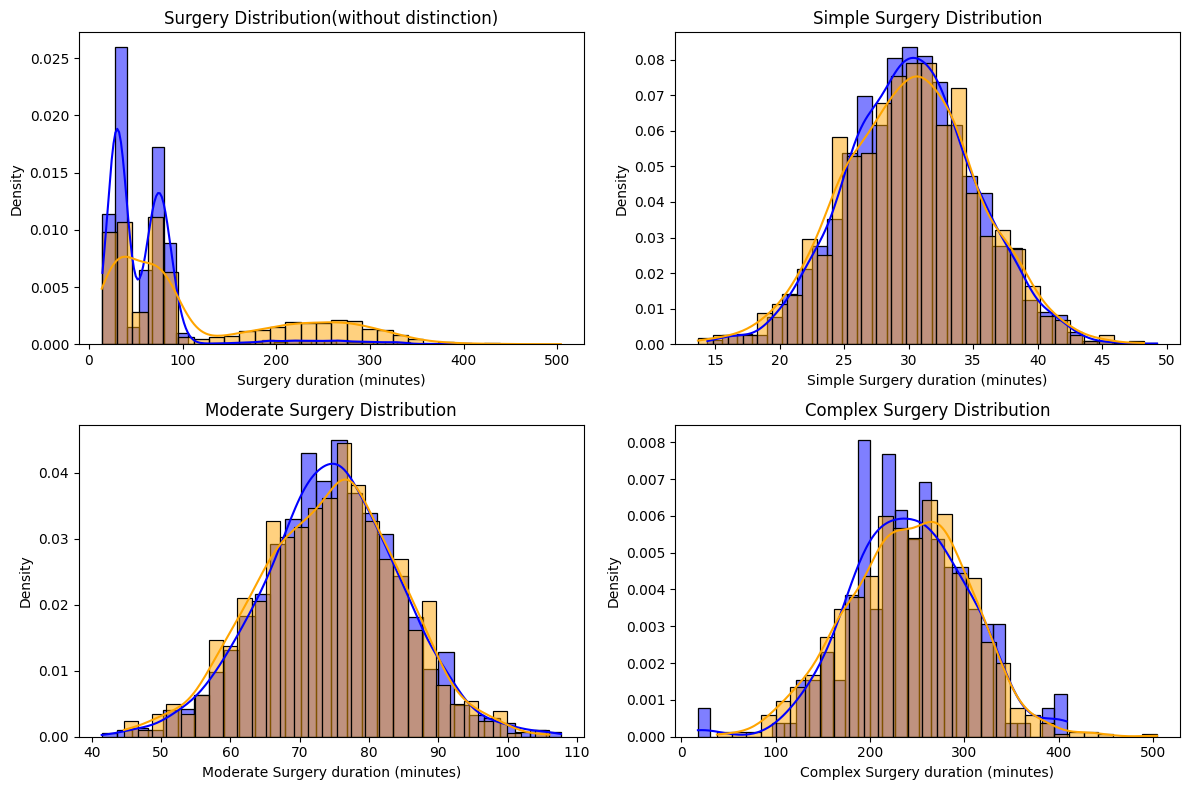

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 x 2 plots

# Plot 1: Surgery Distribution(without distinction)
sns.histplot(df["duration"], bins=30, kde=True, stat="density", color='blue', ax=axes[0, 0], label='Original Data')
sns.histplot(all_generated_durations, bins=30, kde=True, stat="density", color='orange', ax=axes[0, 0], label='Generated Data')
axes[0, 0].set_title('Surgery Distribution(without distinction)')
axes[0, 0].set_xlabel('Surgery duration (minutes)')
axes[0, 0].set_ylabel('Density')

# Plot 2: Simple Surgery
sns.histplot(df.loc[df["type"] == "Simple Surgery"]["duration"], bins=30, kde=True, stat="density", color='blue', ax=axes[0, 1], label='Original Data')
sns.histplot(simple_generated_durations, bins=30, kde=True, stat="density", color='orange', ax=axes[0, 1], label='Generated Data')
axes[0, 1].set_title('Simple Surgery Distribution')
axes[0, 1].set_xlabel('Simple Surgery duration (minutes)')
axes[1, 0].set_ylabel('Density')

# Plot 3: Moderate Surgery
sns.histplot(df.loc[df["type"] == "Moderate Surgery"]["duration"], bins=30, kde=True, stat="density", color='blue', ax=axes[1, 0], label='Original Data')
sns.histplot(moderate_generated_durations, bins=30, kde=True, stat="density", color='orange', ax=axes[1, 0], label='Generated Data')
axes[1, 0].set_title('Moderate Surgery Distribution')
axes[1, 0].set_xlabel('Moderate Surgery duration (minutes)')
axes[1, 0].set_ylabel('Density')

# Plot 4: Complex Surgery
sns.histplot(df.loc[df["type"] == "Complex Surgery"]["duration"], bins=30, kde=True, stat="density", color='blue', ax=axes[1, 1], label='Original Data')
sns.histplot(complex_generated_durations, bins=30, kde=True, stat="density", color='orange', ax=axes[1, 1], label='Generated Data')
axes[1, 1].set_title('Complex Surgery Distribution')
axes[1, 1].set_xlabel('Complex Surgery duration (minutes)')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()

plt.show()



In [16]:
from json import dump

to_dump: dict = {"simple":(simple_surgery.best_fit_dist_name, simple_surgery.best_fit_dist_params),
                 "moderate":(moderate_surgery.best_fit_dist_name, moderate_surgery.best_fit_dist_params),
                 "complex":(complex_surgery.best_fit_dist_name, complex_surgery.best_fit_dist_params),}
path_to_save = "surgery_dist_params.json"
with open(path_to_save, "w") as _:
    dump(to_dump, _, indent=4)